In [6]:
## Here we test out the circuits before using them to make anything

import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

In [2]:
from itertools import combinations, cycle
coeff_dict  = {}

def array_k1(num_qubits):  #assuming num_qubits is even
    array_k = []
    m = num_qubits/2
    if (m)%2!=0: #replace with m-1 for previous results
        for j in range(-int((m)//2),int((m)//2) + 1): #replace with m-1 for previous results
            array_k.append(2*np.pi*j/num_qubits)
    else:
        for j in range(-int((m)//2),int((m)//2)):
            array_k.append(2*np.pi*j/num_qubits)
    return array_k


def recursive_nested(l,num_qubits,coeff_array,coeff = 1,bitstr=''):

    m = int(num_qubits/2) # taking always even number of qubits

    #coeff_dict_2 = {}
    if l==m-1: # m-1, but we start with 0 indexing
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                coeff = coeff*coeff_array[l,i]
                bitstr = bitstr + f'{i}'
                bitstr_sorted = sort_bitstr(bitstr) #to sort the string first
                perm = perm_str2(bitstr,bitstr_sorted) # to compare hamming distance
                if bitstr_sorted in coeff_dict.keys():
                    coeff_dict[bitstr_sorted]+=coeff*perm
                else:
                    coeff_dict[bitstr_sorted] = coeff*perm
            bitstr = bitstr_copy
            coeff = coeff_copy
    if l!=m-1:
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                #print(coeff)
                coeff = coeff*coeff_array[l,i]
                bitstr += str(i)
                recursive_nested(l+1,num_qubits,coeff_array,coeff,bitstr)
            bitstr = bitstr_copy
            coeff = coeff_copy

    return coeff_dict

def sort_bitstr(bitstr):
    bit_array = []
    for i in bitstr:
        bit_array.append(i)
    #print(bit_array)
    bitstr_sorted = ''
    for i in range(len(bit_array)):
        bit_array[i] = int(bit_array[i])
    bit_array.sort()
    #print(bit_array)
    for i in bit_array:
        #print(i,str(i))
        bitstr_sorted += str(i)
        #print(bitstr_sorted)

    return bitstr_sorted

def perm_str2(cmpr,word):

   #  word = 'eyssaasse' base string
   # cmpr = 'seasysaes'  a string to find number of swaps from the base string
    swaps = 0

    # 1)
    chars = {c: [] for c in word}
    [chars[c].append(i) for i, c in enumerate(word)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in cmpr]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1

    #print(swaps)
    if swaps%2 == 0:
        return 1
    else:
        return -1

In [3]:
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state

In [87]:
N = 5 #number of sites
num_qubits = 2*N + 1

In [102]:
def fermi_state_circuit(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(N)
    fermi_state_down = fermi_state(N)
    qc.initialize(fermi_state_up,range(N))
    qc.initialize(fermi_state_down,range(N+1,2*N+1))
    return qc

def fermi_state_circuit2(num_qubits,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(int(num_qubits))
    qc.initialize(fermi_state_up,range(int(num_qubits)))
    return qc


def fermion_state(N,pos_list,num_cl_bits = 0):
    qc = QuantumCircuit(2*N+1,num_cl_bits)
    for i in range(2*N+1):
        if i in pos_list or i==N:
            continue
        else:
            qc.x(i)
    return qc

In [12]:
def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)

    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

In [9]:
test_trotter_steps = 2
angles = [np.pi/4,0,0]

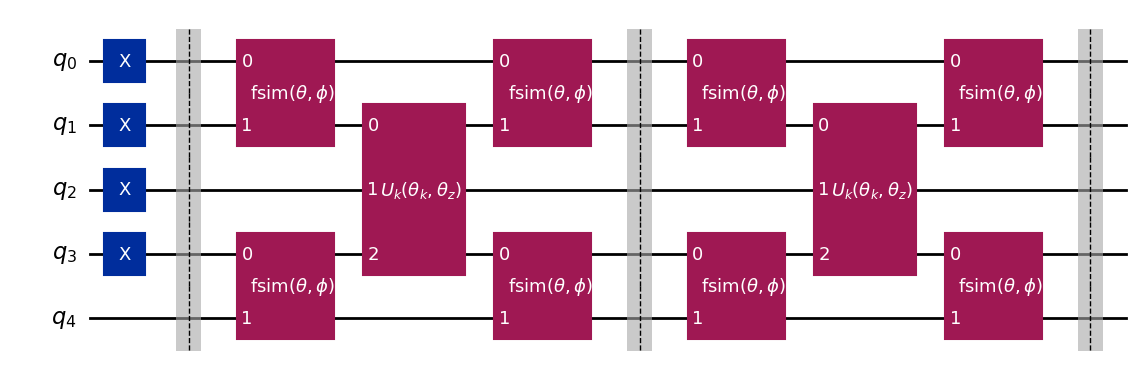

In [71]:
#Now we add the entire kondo circuit

# Let us use the direct 8 by 8 unitary now for the problem
import math as m
import cmath as cm

def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

def circuit_3(N, pos_list, trotter_steps,angles = [0,0,0],theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = fermi_state_circuit(N)
    else:
        qc = fermi_state_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for trotter_step in range(test_trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c-1,c,c+1],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_3(N,[2*N],test_trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')

In [69]:
mat_test = np.array(kondo_unitary(np.pi/6,0).data)
print(mat_test.dot(mat_test.T.conj()))
print(mat_test)

np.allclose(np.eye(len(mat_test)), mat_test.dot(mat_test.T.conj()))

[[1.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 1.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  1.06814835+1.03403453e-17j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.06814835+2.06806906e-17j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 1.        -1.03403453e-17j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.        +0.00

False

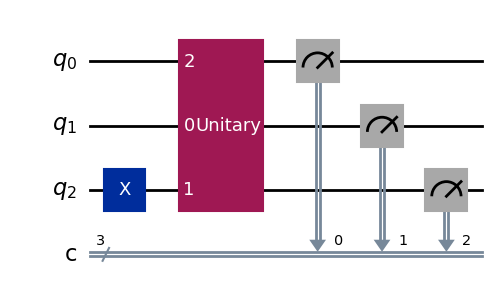

In [74]:
qc_check = QuantumCircuit(3,3)
qc_check.x([2])
qc_check.unitary(kondo_unitary(np.pi/6,np.pi/6),[1,2,0])
qc_check.measure([0,1,2],[0,1,2])
qc_check.draw(output = 'mpl')




In [75]:
sampler = Sampler()
job_exp = sampler.run([qc_check,qc_check],shots = 1000)
result_check = job_exp.result()

In [52]:
abs(m.cos(np.sqrt(2)*np.pi/6) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*np.pi/6))**2

0.7724286404455497

In [76]:
result_check[0].data.c.get_counts()

{'100': 757, '011': 243}

In [53]:
theta_k = np.pi/6

In [116]:
#Let us create the H_t for the system
H_t = 0
theta = angles[0]
for i in range(2*N):
    if i==N-1 or i==N:
        continue
    else:
       H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
H_k = -(theta_k/2)*(SparsePauliOp('XXX')+SparsePauliOp('YXY') + SparsePauliOp('XYY')- SparsePauliOp('YYX')+ 1*(SparsePauliOp('IZZ') - SparsePauliOp('ZZI')))

print(H_t)
print(H_k)

SparsePauliOp(['XXIIIIIIIII', 'YYIIIIIIIII', 'IXXIIIIIIII', 'IYYIIIIIIII', 'IIXXIIIIIII', 'IIYYIIIIIII', 'IIIXXIIIIII', 'IIIYYIIIIII', 'IIIIIIXXIII', 'IIIIIIYYIII', 'IIIIIIIXXII', 'IIIIIIIYYII', 'IIIIIIIIXXI', 'IIIIIIIIYYI', 'IIIIIIIIIXX', 'IIIIIIIIIYY'],
              coeffs=[-0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j,
 -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j,
 -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j,
 -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j, -0.78539816+0.j])
SparsePauliOp(['XXX', 'YXY', 'XYY', 'YYX', 'IZZ', 'ZZI'],
              coeffs=[-0.26179939+0.j, -0.26179939+0.j, -0.26179939+0.j,  0.26179939-0.j,
 -0.26179939+0.j,  0.26179939-0.j])


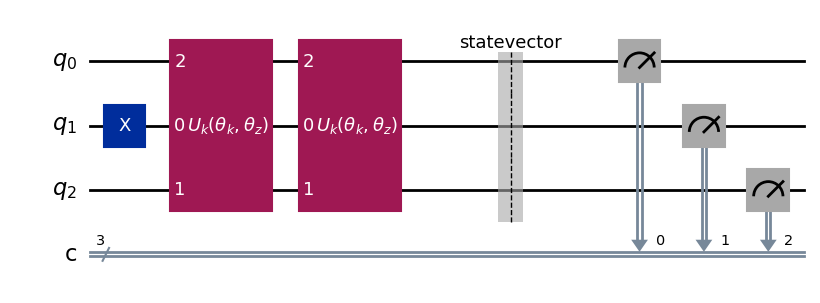

In [117]:
def kondo_circuit(theta_k,steps,pos,num_cl_bits = 3):
    #qc = fermi_state_circuit2(3,num_cl_bits)
    qc = QuantumCircuit(3,num_cl_bits)
    qc.x(pos)
    for i in range(steps):
        qc.unitary(kondo_unitary(theta_k,-theta_k),[1,2,0],label=r'$U_{k}(\theta_k,\theta_z)$')
    qc.save_statevector()
    
    qc.measure([0,1,2],[0,1,2])
    return qc

qc_kondo = kondo_circuit(np.pi/6,2,1)
qc_kondo.draw(output = 'mpl')

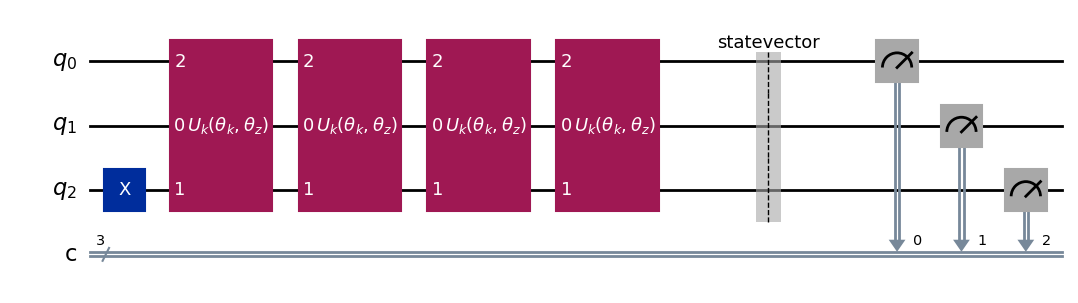

In [118]:


qc_hk_list = []
for i in range(6):
    qc_kondo = kondo_circuit(np.pi/6,i,[2])
    qc_hk_list.append(qc_kondo)

qc_hk_list[4].draw(output = 'mpl')
    



In [119]:
check_ham = [H_k]*6
check_ham_false = [SparsePauliOp('XYX')]*6
estimator =  Estimator(approximation=True)

job_check = estimator.run(qc_hk_list,check_ham,shots = None)
job_check_false = estimator.run(qc_hk_list,check_ham_false,shots = None)
exp_list_check = list(job_check.result().values)
exp_list_check_false = list(job_check_false.result().values)

print(exp_list_check)
print(exp_list_check_false)

[-0.5235987755982988, -0.5235987755982988, -0.5235987755982988, -0.5235987755982987, -0.5235987755982987, -0.5235987755982986]
[0.0, 0.8660254037844386, 0.8660254037844387, 4.886712489901219e-16, -0.8660254037844382, -0.8660254037844388]


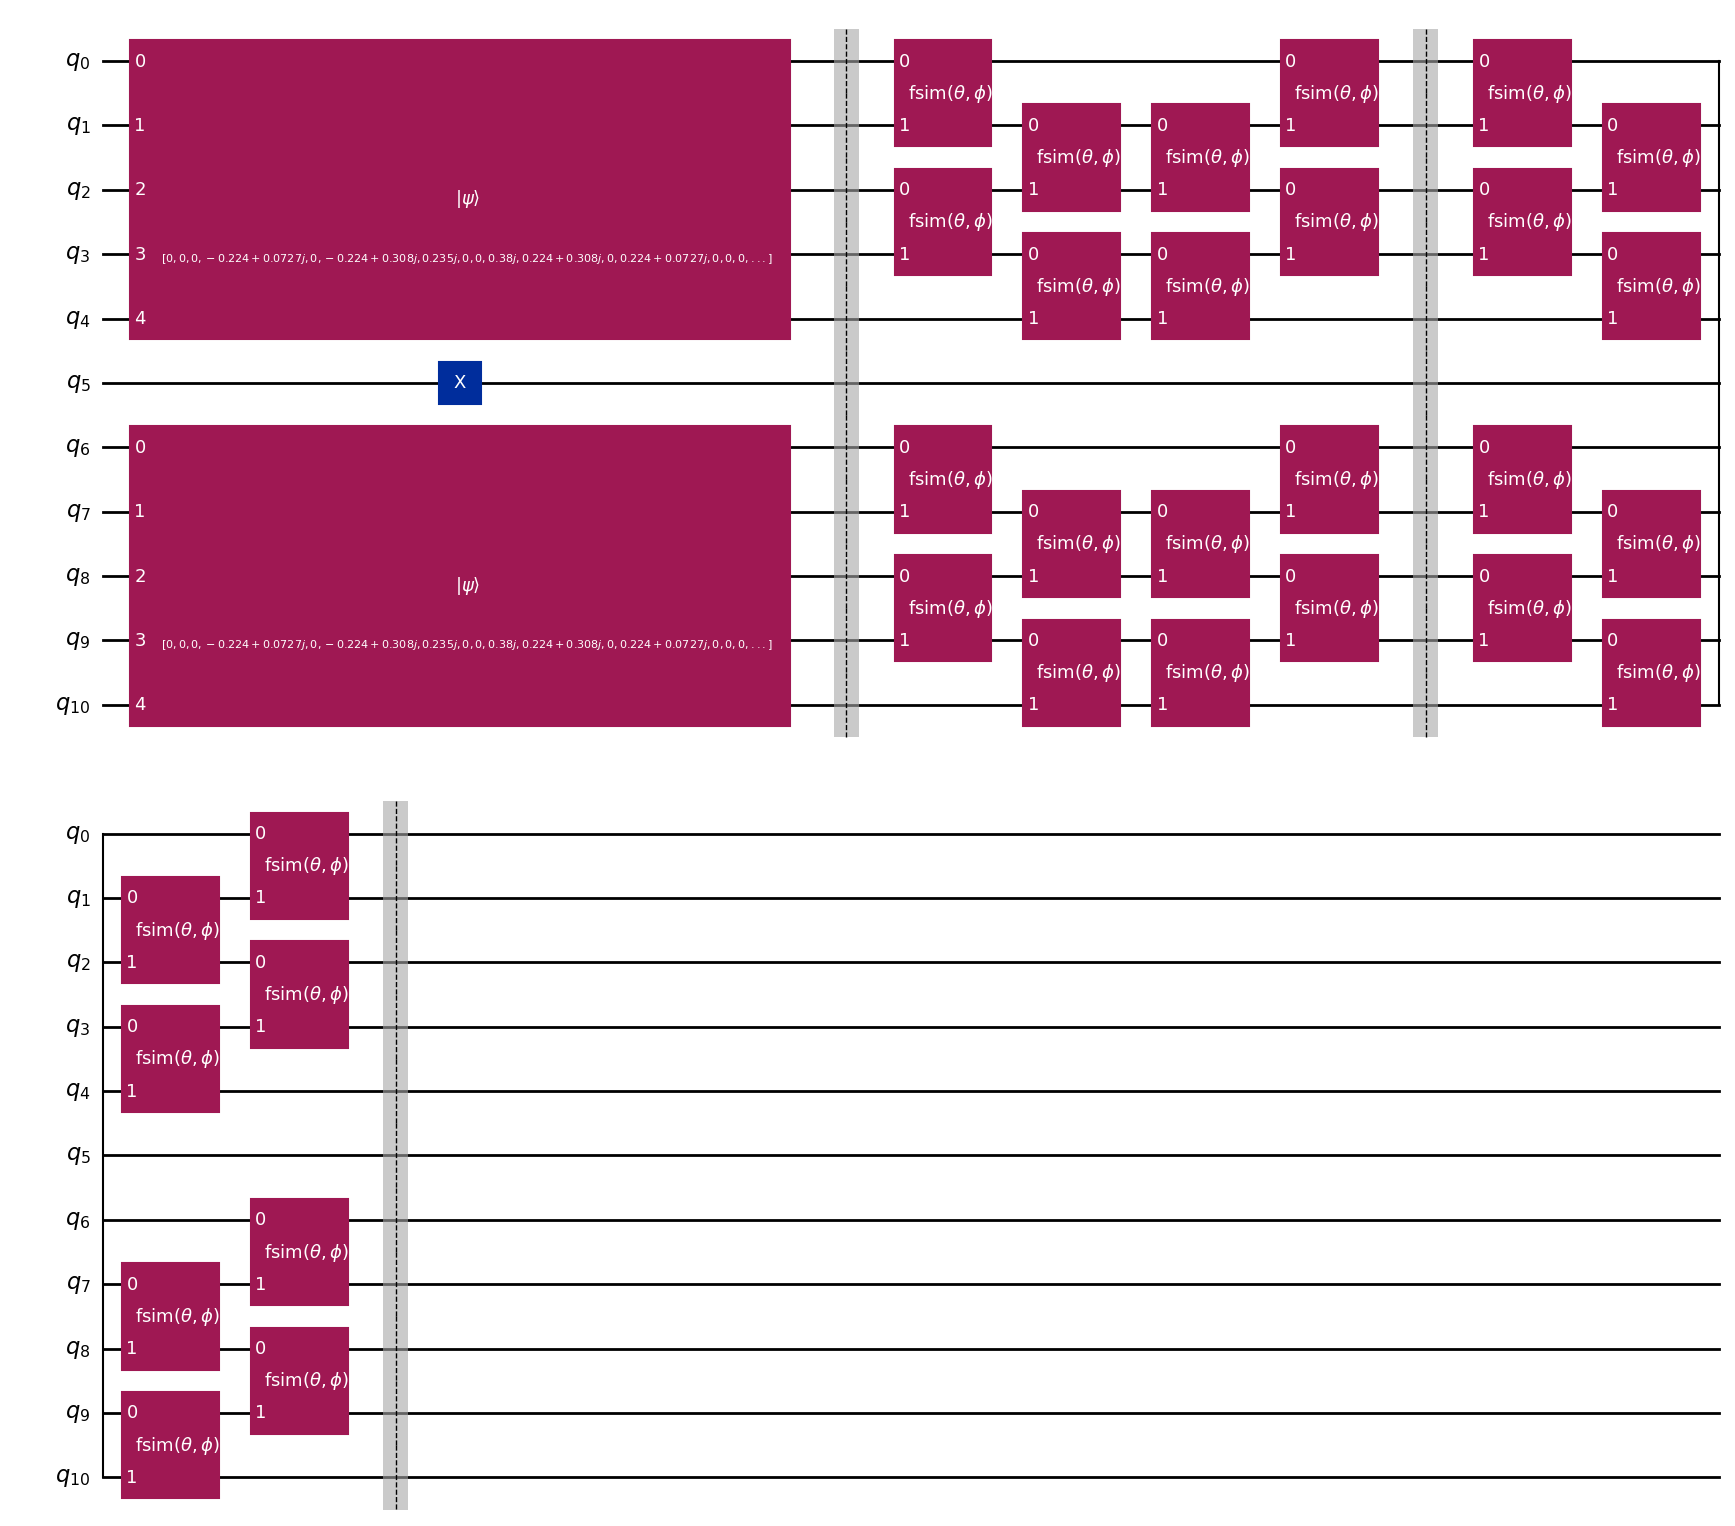

In [93]:
def circuit_WK(N, pos_list, trotter_steps,angles = [0,0,0],theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = fermi_state_circuit(N)
    else:
        qc = fermi_state_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for trotter_step in range(trotter_steps):
        add_fsim_half(qc,angles)
        #qc.unitary(kondo_unitary(theta_k,theta_z),[c-1,c+1,c],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_WK(N,[2*N],test_trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')

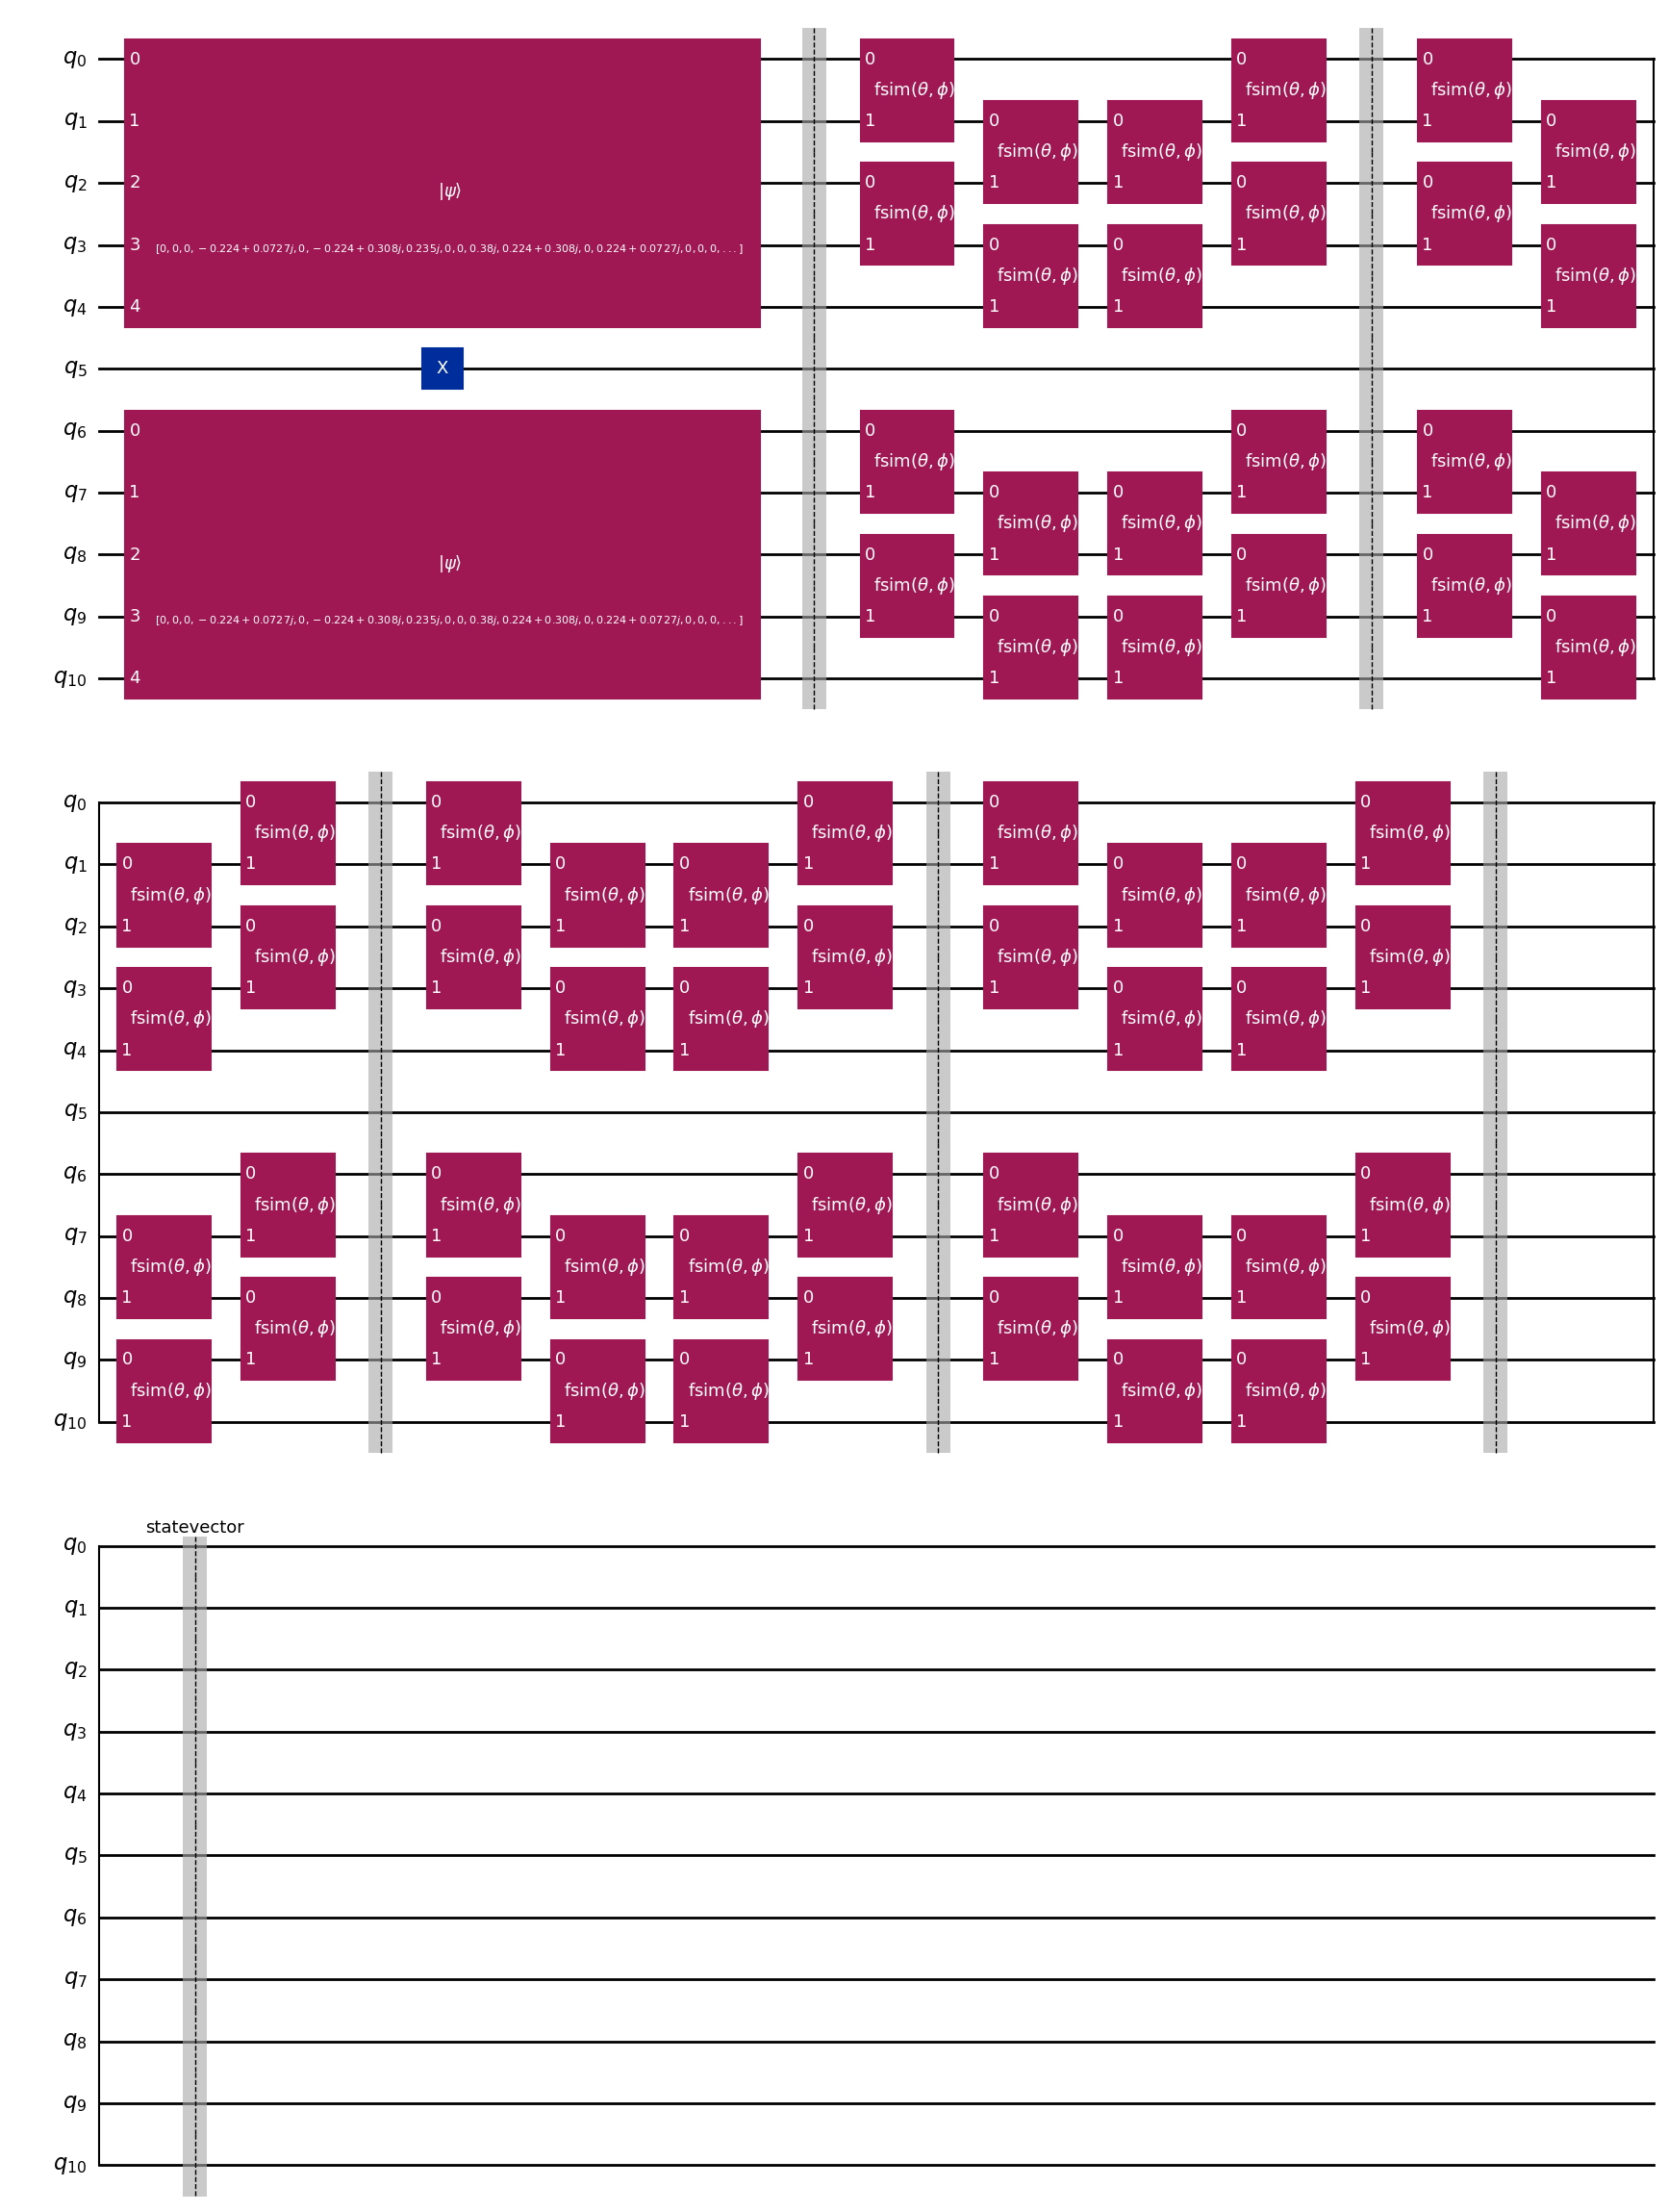

In [99]:
qc_kinetic_list = []
for i in range(6):
    qc_kin = circuit_WK(N,[2*N],i,[np.pi/20,0,0],trotter_barriers = True, save= True)
    qc_kinetic_list.append(qc_kin)

qc_kinetic_list[4].draw(output = 'mpl')


In [100]:
check_kin = [H_t]*6
check_kin_false = [SparsePauliOp('XXIIIIIIIII')]*6
estimator =  Estimator(approximation=True)

job_kin = estimator.run(qc_kinetic_list,check_kin,shots = None)
job_kin_false = estimator.run(qc_kinetic_list,check_kin_false,shots = None)
exp_list_kin = list(job_kin.result().values)
exp_list_kin_false = list(job_kin_false.result().values)

print(exp_list_kin)
print(exp_list_kin_false)

[-6.579837076724052, -6.574084933990371, -6.573384161952399, -6.57972912625382, -6.5900382855845185, -6.598113508518216]
[0.523606797749978, 0.4454057852916613, 0.36021088697344067, 0.2736015265825849, 0.19955887000084838, 0.15562510415073472]


## This confirms that both our circuits have been correctly implemented